# Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pandas.tseries.offsets import BMonthBegin, BMonthEnd, BusinessDay
import pandas_market_calendars as mcal

# Momentum studies based on the book "Dual Momentum Investing: An Innovative Strategy for Higher Returns with Lower Risk", by Gary Antonacci.

The aim of this study was to use the core concept of momentum from the book (mainly trailing X months positive return) applied to brazilian market .

In [2]:
# Dual momentum algorithm proposed by the book
Image(url="images/GEM_rules.jpg", width=500, height=500)

# Data preparation (Brazilian BOVA11 ETF index)

## Downloading data

In [3]:
df = yf.download("BOVA11.SA", interval="1mo")

[*********************100%***********************]  1 of 1 completed


## Drop unnecessary data

In [4]:
df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)

## Defining trailling month positive return criteria

In [5]:
trailing_months = 12
df["ttm"] = df["Adj Close"].pct_change(periods=trailing_months)

## Creating return column

In [6]:
df["monthly_pct"] = df["Adj Close"].pct_change()

In [7]:
df.head(10)

,Adj Close,ttm,monthly_pct
Date,,,
2008-12-01,37.511200,NaN,NaN
2009-01-01,39.599998,NaN,0.055685
2009-02-01,38.750000,NaN,-0.021465
2009-03-01,40.570000,NaN,0.046968
2009-04-01,48.099998,NaN,0.185605
2009-05-01,53.099998,NaN,0.103950
2009-06-01,51.400002,NaN,-0.032015
2009-07-01,54.500000,NaN,0.060311
2009-08-01,56.250000,NaN,0.032110


## Creating boolean auxiliary column to determine if the trailing X-months returns of the index was positive (1) or not (0)

In [8]:
df[str(trailing_months)+"_tm_positive"] = df.apply(lambda x: 1 if x["ttm"] > 0 else 0, axis=1)

In [9]:
df

,Adj Close,ttm,monthly_pct,12_tm_positive
Date,,,,
2008-12-01,37.511200,NaN,NaN,0
2009-01-01,39.599998,NaN,0.055685,0
2009-02-01,38.750000,NaN,-0.021465,0
2009-03-01,40.570000,NaN,0.046968,0
2009-04-01,48.099998,NaN,0.185605,0
...,...,...,...,...
2020-12-31,110.559998,0.015243,-0.035674,1
2021-01-31,105.878929,0.052474,-0.042340,1
2021-03-01,112.226799,0.618267,0.059954,1


## Plotting the distribution of the monthly returns and calculating its skew.

Skew of the returns distribution: -0.46 



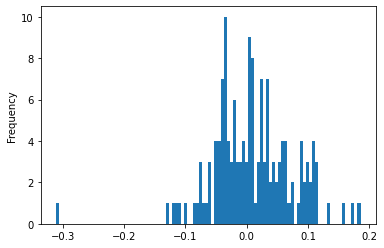

In [10]:
print("Skew of the returns distribution:", round(df["monthly_pct"].skew(), 2), "\n")
df["monthly_pct"].plot(kind="hist", bins=100);

In [11]:
#droping NaN rows
df.dropna(inplace=True)
df

,Adj Close,ttm,monthly_pct,12_tm_positive
Date,,,,
2009-12-01,68.500000,0.826121,0.023916,1
2010-01-01,64.900002,0.638889,-0.052555,1
2010-02-01,66.500000,0.716129,0.024653,1
2010-03-01,70.000000,0.725413,0.052632,1
2010-04-01,66.919998,0.391268,-0.044000,1
...,...,...,...,...
2020-12-31,110.559998,0.015243,-0.035674,1
2021-01-31,105.878929,0.052474,-0.042340,1
2021-03-01,112.226799,0.618267,0.059954,1


## Creating returns of the momentum criteria using the auxiliary boolean column

In [12]:
##Creating returns of the momentum criteria using the auxiliary boolean column
# first return of the series = 0
mom_ret = [0]
# rules to account return after trailing months positive return turns/stay positive (1) or negative
for i in range(1, len(df)):
    #accounting return when momentum rules stay positive
    if df[str(trailing_months)+"_tm_positive"].iloc[i-1] == 1 and df[str(trailing_months)+"_tm_positive"].iloc[i] == 1:
        mom_ret.append(df["monthly_pct"].iloc[i])
    #accounting return when momentum rules turns negative
    if df[str(trailing_months)+"_tm_positive"].iloc[i-1] == 1 and df[str(trailing_months)+"_tm_positive"].iloc[i] == 0:
        mom_ret.append(df["monthly_pct"].iloc[i])
    #accounting return when momentum rules stay negative
    if df[str(trailing_months)+"_tm_positive"].iloc[i-1] == 0 and df[str(trailing_months)+"_tm_positive"].iloc[i] == 0:
        mom_ret.append(0)
    #accounting return when momentum rules turn positive
    if df[str(trailing_months)+"_tm_positive"].iloc[i-1] == 0 and df[str(trailing_months)+"_tm_positive"].iloc[i] == 1:
        mom_ret.append(0)
#assignin new momentum return column to the dataset
df[str(trailing_months)+"tm_ret"] = mom_ret

# df["momentum_ret"] = (df.apply(lambda x: x["monthly_pct"] if x["ttm_positive"] > 0 else 0, axis=1)).shift(-1)

In [13]:
df.dropna(inplace=True)

# Plotting the result of the momentum strategy vs. the index itself

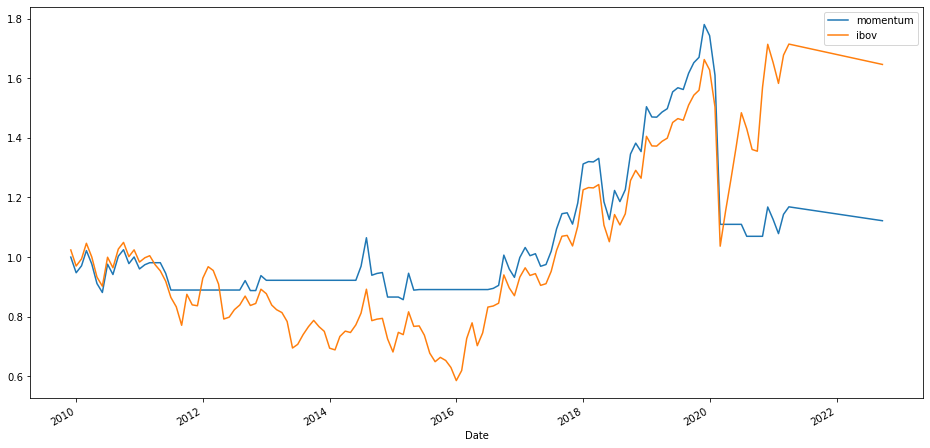

In [14]:
plt.figure(figsize=(16,8))
np.cumprod(1 + df[str(trailing_months)+"tm_ret"]).plot(label="momentum")
np.cumprod(1 + df["monthly_pct"]).plot(label="ibov")
plt.legend();

## Plotting the monthly returns of the momentum investing approach along with its skew.

Skew of the returns distribution: -1.65 



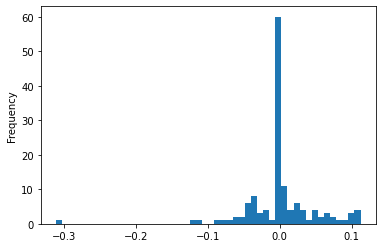

In [15]:
print("Skew of the returns distribution:", round(df[str(trailing_months)+"tm_ret"].skew(), 2), "\n")
df[str(trailing_months)+"tm_ret"].plot(kind="hist", bins=50);

# Creating function to wrangle and calculate data for X positive trailing months returns

In [16]:
def wrangle_data(index, trailing_months):
    df = yf.download(index, interval="1mo")
    #creating trailing x months return
    df[str(trailing_months)+"_tm_ret"] = df["Adj Close"].pct_change(periods=trailing_months)
    #creating monthly %change
    df["monthly_pct"] = df["Adj Close"].pct_change()
    #Creating boolean auxiliary column to determine if the trailing X-months returns of the index was positive (1) or not (0)
    df[str(trailing_months)+"_tm_positive"] = df.apply(lambda x: 1 if x[str(trailing_months)+"_tm_ret"] > 0 else 0, axis=1)
    #drop unnecessary columns
    df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
    #drop NA rows
    df.dropna(inplace=True)
    #Creating returns of the momentum criteria using the auxiliary boolean column
    mom_ret = [0]
    for i in range(1, len(df)):
        if df[str(trailing_months)+"_tm_positive"].iloc[i-1] == 1 and df[str(trailing_months)+"_tm_positive"].iloc[i] == 1:
            mom_ret.append(df["monthly_pct"].iloc[i])
        if df[str(trailing_months)+"_tm_positive"].iloc[i-1] == 1 and df[str(trailing_months)+"_tm_positive"].iloc[i] == 0:
            mom_ret.append(df["monthly_pct"].iloc[i])
        if df[str(trailing_months)+"_tm_positive"].iloc[i-1] == 0 and df[str(trailing_months)+"_tm_positive"].iloc[i] == 0:
            mom_ret.append(0)
        if df[str(trailing_months)+"_tm_positive"].iloc[i-1] == 0 and df[str(trailing_months)+"_tm_positive"].iloc[i] == 1:
            mom_ret.append(0)
    df[str(trailing_months)+"tm_ret"] = mom_ret

    return df[str(trailing_months)+"tm_ret"]

# Creating function to plot X positive trailing month returns

In [17]:
def plot_returns(ret_df):
    #calculating cumulative return for momentum strategy
    y = np.cumprod(1 + ret_df)
    #ploting cumulative return for momentum strategy
    plt.plot(y, label=ret_df.name)
    plt.legend()

    return

# Creating Dataframe for benchmark + trailing positive return momentum strategies

In [18]:
#creating dataframe for benchmark returns
data = yf.download("BOVA11.SA", interval="1mo")["Adj Close"].pct_change().to_frame()
#including columns for X trailing positive returns momentum strategy
for i in range(2, 13):
    data[str(i) + "_tm_positive"] = wrangle_data("BOVA11.SA", i)

data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Adj Close,2_tm_positive,3_tm_positive,4_tm_positive,5_tm_positive,6_tm_positive,7_tm_positive,8_tm_positive,9_tm_positive,10_tm_positive,11_tm_positive,12_tm_positive
Date,,,,,,,,,,,,
2008-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01,0.055685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-01,-0.021465,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-01,0.046968,0.046968,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,0.185605,0.185605,0.185605,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,-0.035674,-0.035674,-0.035674,-0.035674,-0.035674,-0.035674,-0.035674,-0.035674,-0.035674,-0.035674,-0.035674,-0.035674
2021-01-31,-0.042340,-0.042340,-0.042340,-0.042340,-0.042340,-0.042340,-0.042340,-0.042340,-0.042340,-0.042340,-0.042340,-0.042340
2021-03-01,0.059954,0.000000,0.059954,0.059954,0.059954,0.059954,0.059954,0.059954,0.059954,0.059954,0.059954,0.059954


# Ploting benchmark and X trailing months positive returns momentum strategies

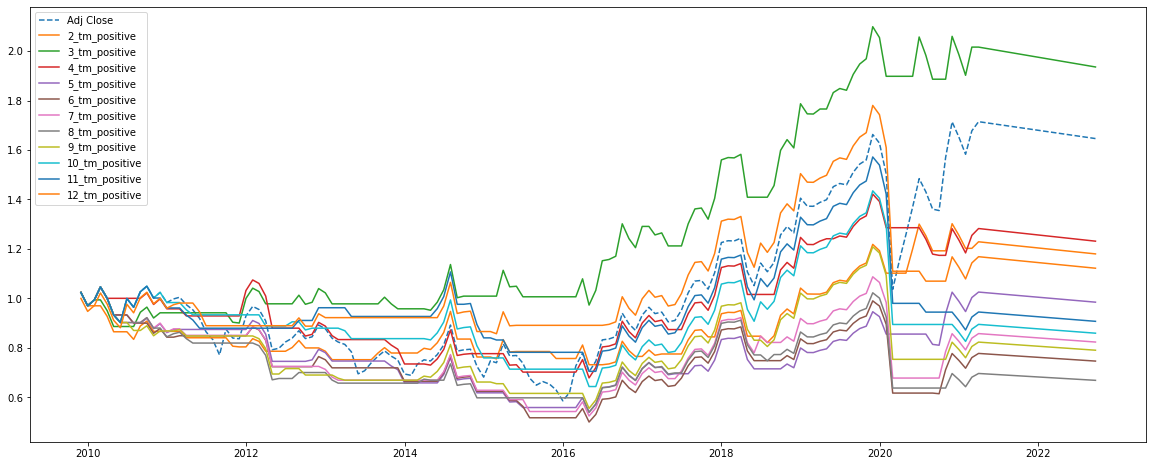

In [19]:
#droping NaN rows
data.dropna(inplace=True)
#creating chart specifying figsize
plt.figure(figsize=(20,8))
#loop for ploting all trailing positive returns momentum strategy
for ret in data:
    #ploting benchmark return with different linestyle
    if ret == "Adj Close":
        plt.plot(np.cumprod(1 + data[ret]), ls = "--", label=data[ret].name)
    #plotting X trailing positive returns momentum strategy
    else:
        plot_returns(data[ret])